In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
import umap

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from autoencoder import Autoencoder

In [2]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [3]:
# Convert MNIST data to numpy arrays
train_images = []
train_labels = []

for batch_idx, (data, target) in enumerate(train_loader):
    data = Variable(data).to('cuda')
    train_images.append(data.cpu().numpy())
    train_labels.append(target.cpu().numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data).to('cuda')
    test_images.append(data.cpu().numpy())
    test_labels.append(target.cpu().numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

https://fairyonice.github.io/Low-and-High-pass-filtering-experiments.html

In [ ]:
sample_image = train_images[0,0]

def draw_circle(shape, diameter):
    '''
    Input:
    shape    : tuple (height, width)
    diameter : scalar
    
    Output:
    np.array of shape that says True within a circle with diameter = around center
    '''
    assert len(shape) == 2
    TF = np.zeros(shape,dtype=np.bool)
    center = np.array(TF.shape)/2.0

    for iy in range(shape[0]):
        for ix in range(shape[1]):
            TF[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < diameter **2
    return(TF)

circle_mask         = draw_circle(shape=sample_image.shape,diameter=2) # Change diameter to target different frequencies
outer_circle_mask   = draw_circle(shape=sample_image.shape, diameter=5)
ring_mask           = outer_circle_mask & ~circle_mask
outside_circle_mask = ~outer_circle_mask

# From the full FFT filter, create a low-, medium-, and high-frequency filter
# low-frequency filter = inner circle
# medium-frequency filter = ring
# high-frequency filter = outside the outer circle
def filter_circle(circle_mask, full_fft_filter):
    temp = np.zeros(full_fft_filter.shape,dtype=complex)
    temp[circle_mask] = full_fft_filter[circle_mask]
    return(temp)


In [30]:
def add_gaussian_noise(image, noise_level=0.1):
    fft_img = np.fft.fftshift(np.fft.fft2(image))

    fft_img_filter = []

    full_fft_filter  = fft_img
    fft_img_filter.append(full_fft_filter)
    
    fft_img_filter = np.array(fft_img_filter)
    fft_img_filter = np.transpose(fft_img_filter,(1,2,0))

    # Multiply all frequencies by (1 + noise_level * random_noise)
    noise = np.random.randn(*fft_img_filter.shape)
    fft_img_filter += noise_level * noise

    np.abs(fft_img_filter)
    img_reco_filter  = np.fft.ifft2(fft_img_filter[:, :, 0])

    return np.abs(img_reco_filter)

def add_low_frequency_noise(image, noise_level=0.1, diameter=4):
    circle_mask = draw_circle(shape=sample_image.shape,diameter=diameter)

    fft_img = np.fft.fftshift(np.fft.fft2(image))
    
    fft_img_filtered_IN = []

    full_fft_filter  = fft_img
    # Inside circle (low-frequency)
    temp = filter_circle(circle_mask, full_fft_filter)
    fft_img_filtered_IN.append(temp)
    
    fft_img_filtered_IN = np.array(fft_img_filtered_IN)
    fft_img_filtered_IN = np.transpose(fft_img_filtered_IN,(1,2,0))

    # Multiply the low-frequency components by (1 + noise_level * random_noise)
    noise = np.random.randn(*fft_img_filtered_IN.shape)
    fft_img_filtered_IN += noise_level * noise

    np.abs(fft_img_filtered_IN)
    img_reco_filtered_IN  = np.fft.ifft2(fft_img_filtered_IN[:, :, 0])

    return np.abs(img_reco_filtered_IN)

def add_medium_frequency_noise(image, noise_level=0.1, inner_diameter=3, outer_diameter=7):
    circle_mask         = draw_circle(shape=sample_image.shape,diameter=inner_diameter)
    outer_circle_mask   = draw_circle(shape=sample_image.shape, diameter=outer_diameter)
    ring_mask           = outer_circle_mask & ~circle_mask

    fft_img = np.fft.fftshift(np.fft.fft2(image))
    
    fft_img_filtered_RING = []

    full_fft_filter  = fft_img
    # Ring (medium-frequency)
    temp = filter_circle(ring_mask, full_fft_filter)
    fft_img_filtered_RING.append(temp)
    fft_img_filtered_RING = np.array(fft_img_filtered_RING)
    fft_img_filtered_RING = np.transpose(fft_img_filtered_RING,(1,2,0))

    # Multiply the medium-frequency components by (1 + noise_level * random_noise)
    noise = np.random.randn(*fft_img_filtered_RING.shape)
    fft_img_filtered_RING += noise_level * noise

    np.abs(fft_img_filtered_RING)
    img_reco_filtered_RING = np.fft.ifft2(fft_img_filtered_RING[:, :, 0])

    return np.abs(img_reco_filtered_RING)

def add_high_frequency_noise(image, noise_level=0.1, diameter=8):
    outer_circle_mask   = draw_circle(shape=sample_image.shape, diameter=diameter)
    outside_circle_mask = ~outer_circle_mask

    fft_img = np.fft.fftshift(np.fft.fft2(image))

    fft_img_filtered_OUT = []

    full_fft_filter  = fft_img
    # Outside circle (high-frequency)
    temp = filter_circle(outside_circle_mask, full_fft_filter)
    fft_img_filtered_OUT.append(temp) 

    fft_img_filtered_OUT = np.array(fft_img_filtered_OUT)
    fft_img_filtered_OUT = np.transpose(fft_img_filtered_OUT,(1,2,0))

    # Multiply the high-frequency components by (1 + noise_level * random_noise)
    noise = np.random.randn(*fft_img_filtered_OUT.shape)
    fft_img_filtered_OUT += noise_level * noise

    np.abs(fft_img_filtered_OUT)
    img_reco_filtered_OUT = np.fft.ifft2(fft_img_filtered_OUT[:, :, 0])

    return np.abs(img_reco_filtered_OUT)

### Load models

In [7]:
modelpath = '/home/david/sparsify_models/good_models/01/'

sae_model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)
dae_model = Autoencoder(n_input=784, n_hidden_ls=[512, 128, 32], n_layers=3)

sae_weights = torch.load(modelpath + 'SAE/model_weights_epoch49.pth')
sae_model.load_state_dict(sae_weights)

dae_weights = torch.load(modelpath + 'DAE/model_weights_epoch49.pth')
dae_model.load_state_dict(dae_weights)

/tmp/ipykernel_59370/1097132316.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_weights = torch.load(modelpath + 'SAE/model_weights_epoch49.pth')
/tmp/ipykernel_5937

<All keys matched successfully>

### Retrieve encodings

In [32]:
sae_train_encodings = []

with torch.no_grad():
    for image in train_images:
        image = torch.tensor(image).to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_train_encodings.append(encoded.cpu().detach().numpy())

sae_train_encodings = np.concatenate(sae_train_encodings)


sae_test_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_test_encodings.append(encoded.cpu().detach().numpy())

sae_test_encodings = np.concatenate(sae_test_encodings)

In [34]:
dae_train_encodings = []

with torch.no_grad():
    for image in train_images:
        image = torch.tensor(image).to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = dae_model(input)
        dae_train_encodings.append(encoded.cpu().detach().numpy())

dae_train_encodings = np.concatenate(dae_train_encodings)


dae_test_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = dae_model(input)
        dae_test_encodings.append(encoded.cpu().detach().numpy())

dae_test_encodings = np.concatenate(dae_test_encodings)

### Classification accuracy of SAE and DAE encodings with a Linear SVC

In [35]:
sae_svc = LinearSVC(max_iter=1000, C=1.0)
sae_svc.fit(sae_train_encodings, train_labels)

sae_predictions = sae_svc.predict(sae_test_encodings)
accuracy = accuracy_score(test_labels, sae_predictions)
print(f'SVC trained on SAE encodings - Accuracy: {accuracy:.4f}')

SVC trained on SAE encodings - Accuracy: 0.8868


In [36]:
dae_svc = LinearSVC(max_iter=1000, C=1.0)
dae_svc.fit(dae_train_encodings, train_labels)

dae_predictions = dae_svc.predict(dae_test_encodings)
accuracy = accuracy_score(test_labels, dae_predictions)
print(f'SVC trained on DAE encodings - Accuracy: {accuracy:.4f}')

SVC trained on DAE encodings - Accuracy: 0.8870


### Adding noise

In [6]:
from tqdm.notebook import tqdm

gaussian_noise_images = []
low_freq_noise_images = []
medium_freq_noise_images = []
high_freq_noise_images = []

for image in tqdm(test_images[:, 0], desc='Adding noise to images'):
    gaussian_noise_images.append(add_gaussian_noise(image))
    low_freq_noise_images.append(add_low_frequency_noise(image))
    medium_freq_noise_images.append(add_medium_frequency_noise(image))
    high_freq_noise_images.append(add_high_frequency_noise(image))

Adding noise to images:   0%|          | 0/10000 [00:00<?, ?it/s]

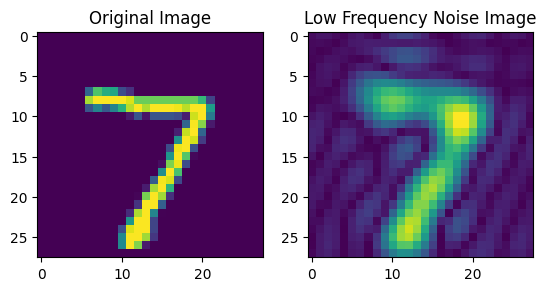

In [41]:
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(test_images[0].reshape(28, 28))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(low_freq_noise_images[0].reshape(28, 28))
plt.title('Low Frequency Noise Image')

plt.show()

### Adding noise to the encodings

In [14]:
sae_train_noisy_encodings = []
sae_test_noisy_encodings = []
dae_train_noisy_encodings = []
dae_test_noisy_encodings = []

for image in sae_train_encodings:
    sae_train_noisy_encodings.append(random_noise(image, mode='gaussian', var=0.5))

for image in sae_test_encodings:
    sae_test_noisy_encodings.append(random_noise(image, mode='gaussian', var=0.5))

for image in dae_train_encodings:
    dae_train_noisy_encodings.append(random_noise(image, mode='gaussian', var=0.5))

for image in dae_test_encodings:
    dae_test_noisy_encodings.append(random_noise(image, mode='gaussian', var=0.5))

In [15]:
noisy_encoding_predictions = sae_svc.predict(sae_test_noisy_encodings)
accuracy = accuracy_score(test_labels, noisy_encoding_predictions)
print(f'SVC trained on SAE encodings - Noisy - Accuracy: {accuracy:.4f}')

noisy_encoding_predictions = dae_svc.predict(dae_test_noisy_encodings)
accuracy = accuracy_score(test_labels, noisy_encoding_predictions)
print(f'SVC trained on DAE encodings - Noisy - Accuracy: {accuracy:.4f}')

SVC trained on SAE encodings - Noisy - Accuracy: 0.5482
SVC trained on DAE encodings - Noisy - Accuracy: 0.2026


In [16]:
#SVC trained on noisy encodings
noisy_encoding_sae_svc = LinearSVC(max_iter=1000, C=1.0)
noisy_encoding_sae_svc.fit(sae_train_noisy_encodings, train_labels)
predictions = noisy_encoding_sae_svc.predict(sae_test_noisy_encodings)
accuracy = accuracy_score(test_labels, predictions)
print(f'SVC trained on SAE encodings - Noisy - Accuracy: {accuracy:.4f}')

noisy_encoding_dae_svc = LinearSVC(max_iter=1000, C=1.0)
noisy_encoding_dae_svc.fit(dae_train_noisy_encodings, train_labels)
predictions = noisy_encoding_dae_svc.predict(dae_test_noisy_encodings)
accuracy = accuracy_score(test_labels, predictions)
print(f'SVC trained on DAE encodings - Noisy - Accuracy: {accuracy:.4f}')

SVC trained on SAE encodings - Noisy - Accuracy: 0.6195
SVC trained on DAE encodings - Noisy - Accuracy: 0.3746


### Adding noise to the images

In [17]:
noisy_train_images = add_gaussian_noise(train_images, 0.5)
noisy_test_images = add_gaussian_noise(test_images, 0.5)

sae_train_encodings_from_noisy_images = []

with torch.no_grad():
    for image in noisy_train_images:
        image = torch.tensor(image).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_train_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

sae_train_encodings_from_noisy_images = np.concatenate(sae_train_encodings_from_noisy_images)


sae_test_encodings_from_noisy_images = []

with torch.no_grad():
    for image in noisy_test_images:
        image = torch.tensor(image).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_test_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

sae_test_encodings_from_noisy_images = np.concatenate(sae_test_encodings_from_noisy_images)

In [18]:
dae_train_encodings_from_noisy_images = []

with torch.no_grad():
    for image in noisy_train_images:
        image = torch.tensor(image).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = dae_model(input)
        dae_train_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

dae_train_encodings_from_noisy_images = np.concatenate(dae_train_encodings_from_noisy_images)


dae_test_encodings_from_noisy_images = []

with torch.no_grad():
    for image in noisy_test_images:
        image = torch.tensor(image).float().to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = dae_model(input)
        dae_test_encodings_from_noisy_images.append(encoded.cpu().detach().numpy())

dae_test_encodings_from_noisy_images = np.concatenate(dae_test_encodings_from_noisy_images)

### Classification accuracy of noisy SAE and DAE encodings with a Linear SVC

In [19]:
sae_noisy_predictions = sae_svc.predict(sae_test_encodings_from_noisy_images)
accuracy = accuracy_score(sae_noisy_predictions, test_labels)
print(f'SVC trained on SAE encodings - Accuracy on noisy encodings: {accuracy:.4f}')

dae_noisy_predictions = dae_svc.predict(dae_test_encodings_from_noisy_images)
accuracy = accuracy_score(dae_noisy_predictions, test_labels)
print(f'SVC trained on DAE encodings - Accuracy on noisy encodings: {accuracy:.4f}')

SVC trained on SAE encodings - Accuracy on noisy encodings: 0.4347
SVC trained on DAE encodings - Accuracy on noisy encodings: 0.4671


### Classification accuracy of noisy SAE and DAE encodings with a Linear SVC (trained on noisy data)

In [20]:
sae_noisy_svc = LinearSVC(max_iter=1000, C=1.0)
sae_noisy_svc.fit(sae_train_encodings_from_noisy_images, train_labels)

sae_noisy_predictions = sae_noisy_svc.predict(sae_test_encodings_from_noisy_images)
accuracy = accuracy_score(test_labels, sae_noisy_predictions)
print(f'SVC trained on noisy SAE encodings - Accuracy: {accuracy:.4f}')

SVC trained on noisy SAE encodings - Accuracy: 0.7664


In [21]:
dae_noisy_svc = LinearSVC(max_iter=1000, C=1.0)
dae_noisy_svc.fit(dae_train_encodings_from_noisy_images, train_labels)

dae_noisy_predictions = dae_noisy_svc.predict(dae_test_encodings_from_noisy_images)
accuracy = accuracy_score(test_labels, dae_noisy_predictions)
print(f'SVC trained on noisy DAE encodings - Accuracy: {accuracy:.4f}')

SVC trained on noisy DAE encodings - Accuracy: 0.7489


### Plotting results

In [52]:
data = []

noise_levels = [0, 0.1, 0.5, 0.9]
noise_frequencies = ['low', 'medium', 'high']

for noise_level in tqdm(noise_levels, desc='Noise Levels'):
    for frequency in noise_frequencies:

        noisy_images = []
        if frequency == 'low':
            for image in test_images:
                noisy_images.append(add_low_frequency_noise(image[0, :, :], noise_level))
        elif frequency == 'medium':
            for image in test_images:
                noisy_images.append(add_medium_frequency_noise(image[0, :, :], noise_level))
        elif frequency == 'high':
            for image in test_images:
                noisy_images.append(add_high_frequency_noise(image[0, :, :], noise_level))
        
        sae_encodings_from_noisy = []
        dae_encodings_from_noisy = []

        for image in noisy_images:
            image = torch.tensor(image).float().to('cuda')
            input = image.view(1, -1).to('cpu')
            encoded, decoded = sae_model(input)
            sae_encodings_from_noisy.append(encoded.cpu().detach().numpy())
            encoded, decoded = dae_model(input.to('cpu'))
            dae_encodings_from_noisy.append(encoded.cpu().detach().numpy())

        sae_encodings_from_noisy = np.concatenate(sae_encodings_from_noisy, axis=0)
        dae_encodings_from_noisy = np.concatenate(dae_encodings_from_noisy, axis=0)

        sae_noisy_predictions = sae_svc.predict(sae_encodings_from_noisy)
        dae_noisy_predictions = dae_svc.predict(dae_encodings_from_noisy)
        
        sae_noisy_accuracy = accuracy_score(sae_noisy_predictions, test_labels)
        dae_noisy_accuracy = accuracy_score(dae_noisy_predictions, test_labels)

        data.append({
            'noise_level': noise_level,
            'noise_frequency': frequency,
            'sae_noisy_accuracy': sae_noisy_accuracy,
            'dae_noisy_accuracy': dae_noisy_accuracy
        })

Noise Levels:   0%|          | 0/4 [00:00<?, ?it/s]

In [57]:
data

[{'noise_level': 0,
  'noise_frequency': 'low',
  'sae_noisy_accuracy': 0.8031,
  'dae_noisy_accuracy': 0.8134},
 {'noise_level': 0,
  'noise_frequency': 'medium',
  'sae_noisy_accuracy': 0.2785,
  'dae_noisy_accuracy': 0.2706},
 {'noise_level': 0,
  'noise_frequency': 'high',
  'sae_noisy_accuracy': 0.1553,
  'dae_noisy_accuracy': 0.1488},
 {'noise_level': 0.1,
  'noise_frequency': 'low',
  'sae_noisy_accuracy': 0.8033,
  'dae_noisy_accuracy': 0.8126},
 {'noise_level': 0.1,
  'noise_frequency': 'medium',
  'sae_noisy_accuracy': 0.2786,
  'dae_noisy_accuracy': 0.2708},
 {'noise_level': 0.1,
  'noise_frequency': 'high',
  'sae_noisy_accuracy': 0.1544,
  'dae_noisy_accuracy': 0.1483},
 {'noise_level': 0.5,
  'noise_frequency': 'low',
  'sae_noisy_accuracy': 0.7963,
  'dae_noisy_accuracy': 0.8081},
 {'noise_level': 0.5,
  'noise_frequency': 'medium',
  'sae_noisy_accuracy': 0.2765,
  'dae_noisy_accuracy': 0.2696},
 {'noise_level': 0.5,
  'noise_frequency': 'high',
  'sae_noisy_accuracy': 

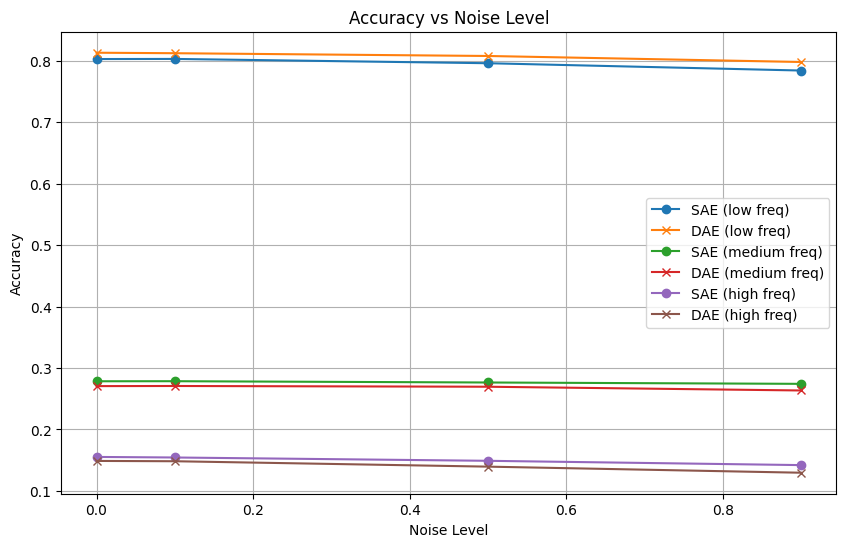

In [58]:
groups = {}
for entry in data:
    key = entry['noise_frequency']
    if key not in groups:
        groups[key] = {'noise_level': [], 'sae_noisy_accuracy': [], 'dae_noisy_accuracy': []}
    groups[key]['noise_level'].append(entry['noise_level'])
    groups[key]['sae_noisy_accuracy'].append(entry['sae_noisy_accuracy'])
    groups[key]['dae_noisy_accuracy'].append(entry['dae_noisy_accuracy'])

# Plot
plt.figure(figsize=(10, 6))

for noise_frequency, values in groups.items():
    plt.plot(values['noise_level'], values['sae_noisy_accuracy'], marker='o', label=f"SAE ({noise_frequency} freq)")
    plt.plot(values['noise_level'], values['dae_noisy_accuracy'], marker='x', label=f"DAE ({noise_frequency} freq)")

plt.title("Accuracy vs Noise Level")
plt.xlabel("Noise Level")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [66]:
sae_test_encodings = []
dae_test_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        sae_test_encodings.append(encoded.cpu().detach().numpy())

sae_test_encodings = np.concatenate(sae_test_encodings)

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).to('cuda')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae_model(input)
        dae_test_encodings.append(encoded.cpu().detach().numpy())
dae_test_encodings = np.concatenate(dae_test_encodings)


sae_test_encodings_low_freq_noise_image = []
dae_test_encodings_low_freq_noise_image = []

for image in test_images:
    image = torch.tensor(add_low_frequency_noise(image[0, :, :])).float().to('cuda')
    input = image.view(1, -1).to('cpu')
    encoded, decoded = sae_model(input)
    sae_test_encodings_low_freq_noise_image.append(encoded.cpu().detach().numpy())
    encoded, decoded = dae_model(input)
    dae_test_encodings_low_freq_noise_image.append(encoded.cpu().detach().numpy())

sae_test_encodings_low_freq_noise_image = np.concatenate(sae_test_encodings_low_freq_noise_image)
dae_test_encodings_low_freq_noise_image = np.concatenate(dae_test_encodings_low_freq_noise_image)


sae_test_encodings_medium_freq_noise_image = []
dae_test_encodings_medium_freq_noise_image = []

for image in test_images:
    image = torch.tensor(add_medium_frequency_noise(image[0, :, :])).float().to('cuda')
    input = image.view(1, -1).to('cpu')
    encoded, decoded = sae_model(input)
    sae_test_encodings_medium_freq_noise_image.append(encoded.cpu().detach().numpy())
    encoded, decoded = dae_model(input)
    dae_test_encodings_medium_freq_noise_image.append(encoded.cpu().detach().numpy())

sae_test_encodings_medium_freq_noise_image = np.concatenate(sae_test_encodings_medium_freq_noise_image)
dae_test_encodings_medium_freq_noise_image = np.concatenate(dae_test_encodings_medium_freq_noise_image)


sae_test_encodings_high_freq_noise_image = []
dae_test_encodings_high_freq_noise_image = []

for image in test_images:
    image = torch.tensor(add_high_frequency_noise(image[0, :, :])).float().to('cuda')
    input = image.view(1, -1).to('cpu')
    encoded, decoded = sae_model(input)
    sae_test_encodings_high_freq_noise_image.append(encoded.cpu().detach().numpy())
    encoded, decoded = dae_model(input)
    dae_test_encodings_high_freq_noise_image.append(encoded.cpu().detach().numpy())

sae_test_encodings_high_freq_noise_image = np.concatenate(sae_test_encodings_high_freq_noise_image)
dae_test_encodings_high_freq_noise_image = np.concatenate(dae_test_encodings_high_freq_noise_image)

In [67]:
reducer = umap.UMAP(n_components=2)
sae_umap = reducer.fit_transform(sae_test_encodings)

reducer = umap.UMAP(n_components=2)
dae_umap = reducer.fit_transform(dae_test_encodings)

reducer = umap.UMAP(n_components=2)
noisy_sae_umap_low = reducer.fit_transform(sae_test_encodings_low_freq_noise_image)

reducer = umap.UMAP(n_components=2)
noisy_dae_umap_low = reducer.fit_transform(dae_test_encodings_low_freq_noise_image)

reducer = umap.UMAP(n_components=2)
noisy_sae_umap_medium = reducer.fit_transform(sae_test_encodings_medium_freq_noise_image)

reducer = umap.UMAP(n_components=2)
noisy_dae_umap_medium = reducer.fit_transform(dae_test_encodings_medium_freq_noise_image)

reducer = umap.UMAP(n_components=2)
noisy_sae_umap_high = reducer.fit_transform(sae_test_encodings_high_freq_noise_image)

reducer = umap.UMAP(n_components=2)
noisy_dae_umap_high = reducer.fit_transform(dae_test_encodings_high_freq_noise_image)

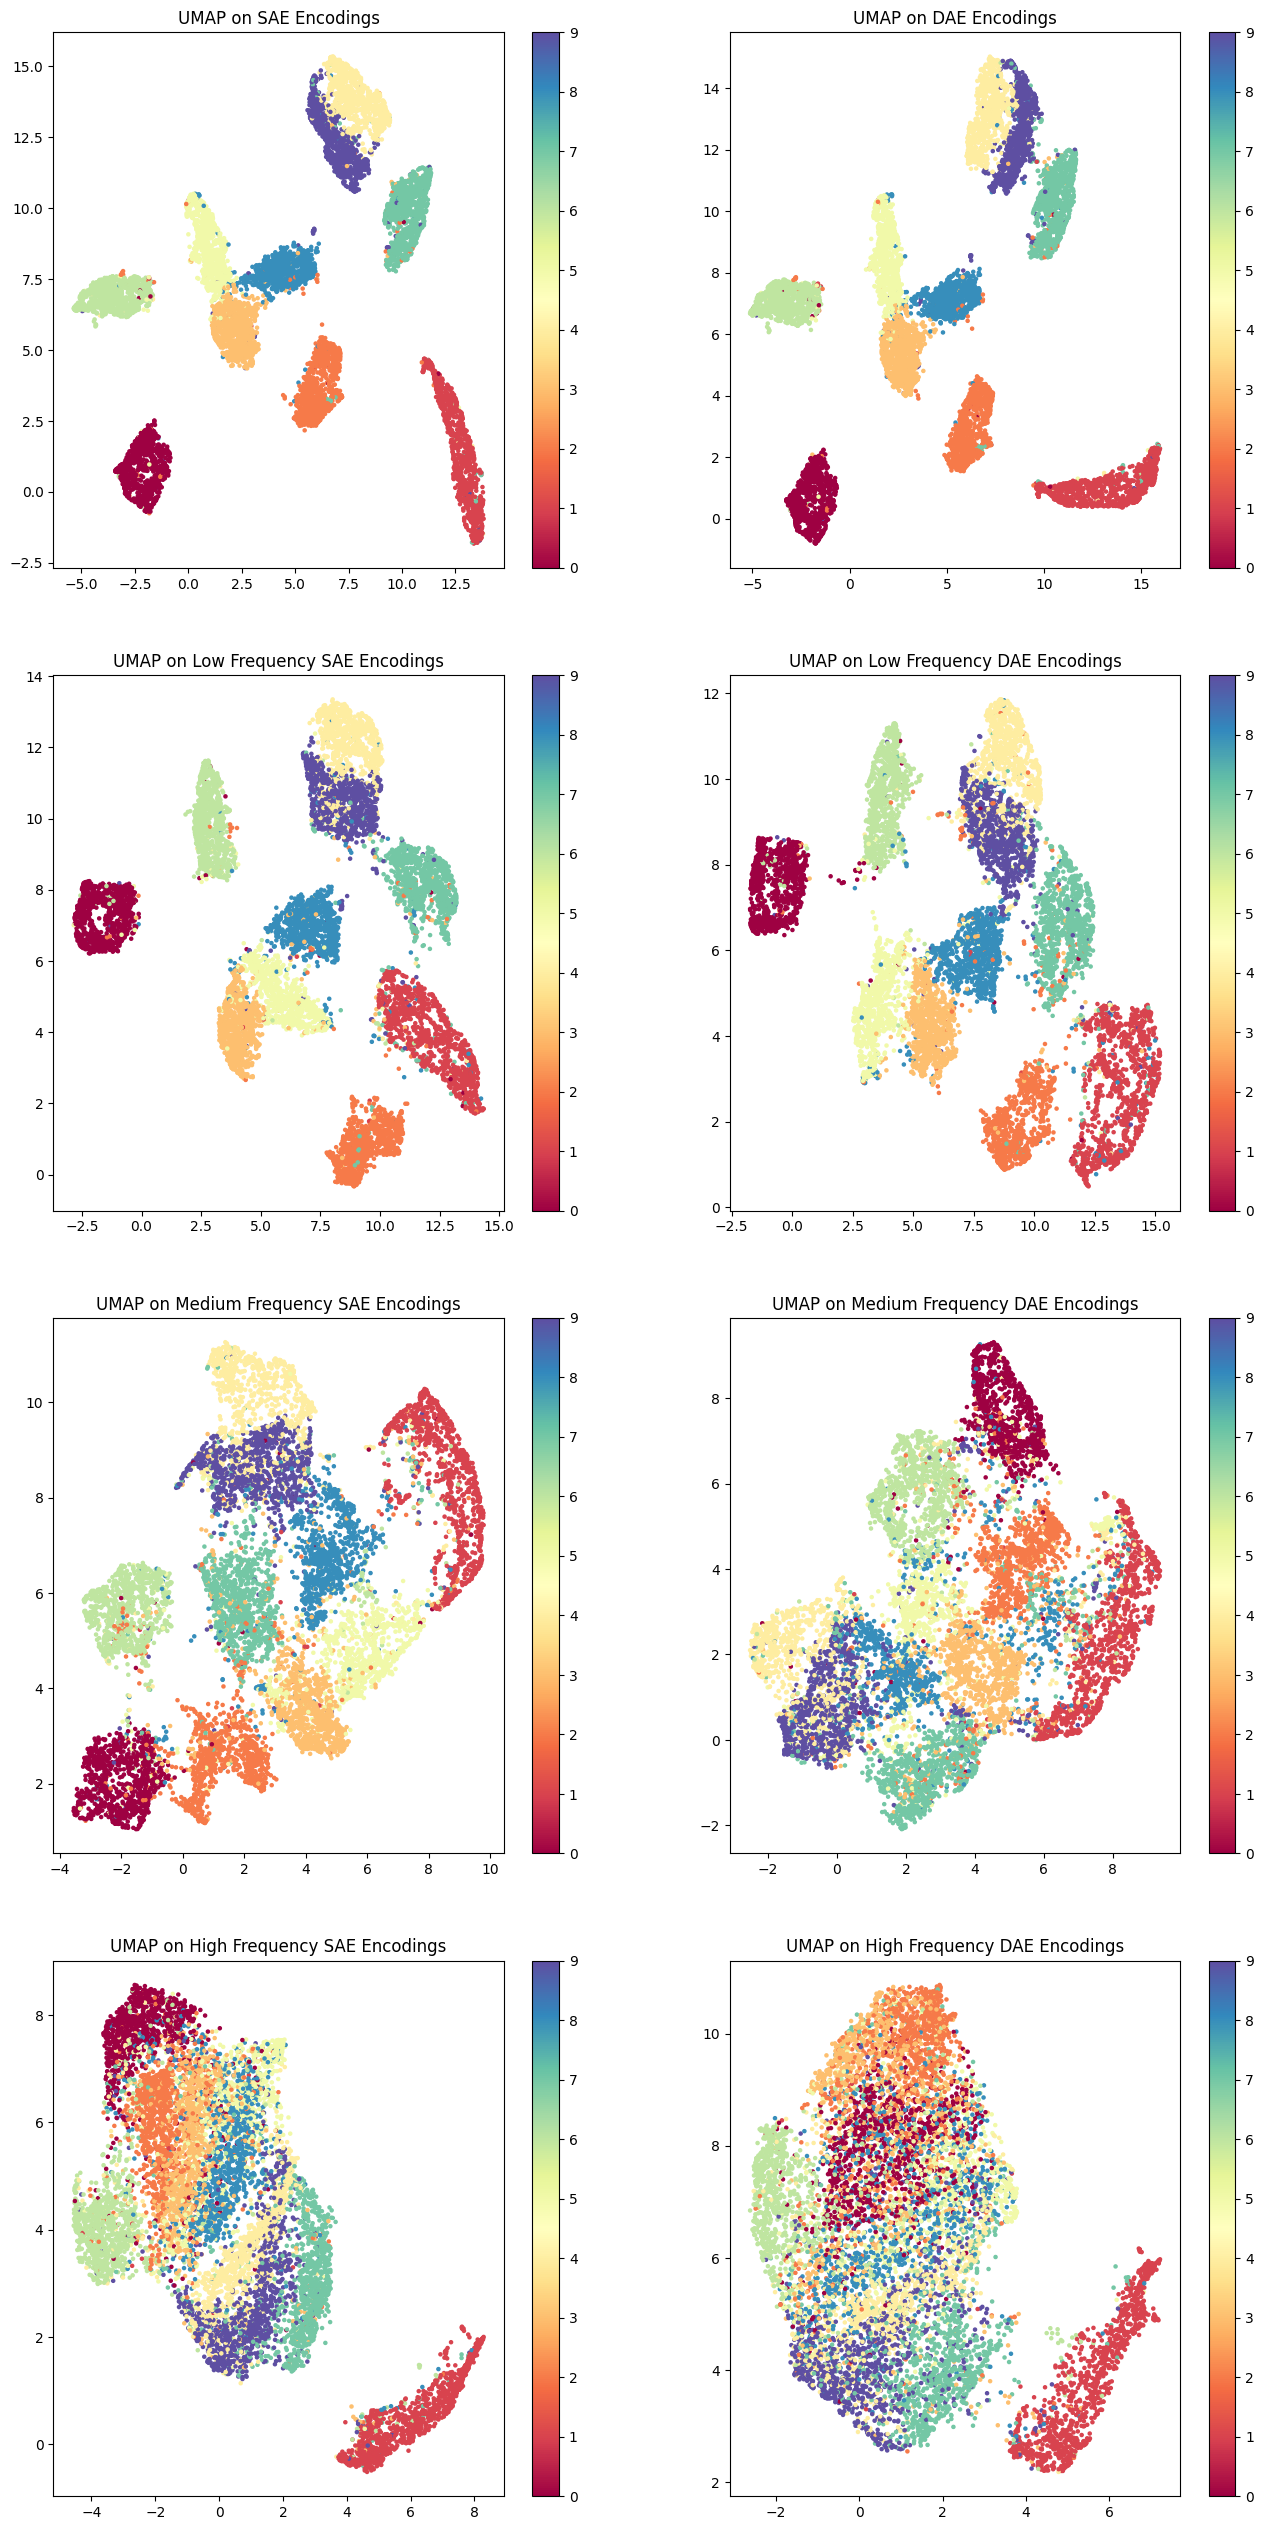

In [71]:
plt.figure(figsize=(16, 32))

plt.subplot(4, 2, 1)
scatter = plt.scatter(sae_umap[:, 0], sae_umap[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on SAE Encodings")

plt.subplot(4, 2, 2)
scatter = plt.scatter(dae_umap[:, 0], dae_umap[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on DAE Encodings")

plt.subplot(4, 2, 3)
scatter = plt.scatter(noisy_sae_umap_low[:, 0], noisy_sae_umap_low[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on Low Frequency SAE Encodings")

plt.subplot(4, 2, 4)
scatter = plt.scatter(noisy_dae_umap_low[:, 0], noisy_dae_umap_low[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on Low Frequency DAE Encodings")

plt.subplot(4, 2, 5)
scatter = plt.scatter(noisy_sae_umap_medium[:, 0], noisy_sae_umap_medium[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on Medium Frequency SAE Encodings")

plt.subplot(4, 2, 6)
scatter = plt.scatter(noisy_dae_umap_medium[:, 0], noisy_dae_umap_medium[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on Medium Frequency DAE Encodings")

plt.subplot(4, 2, 7)
scatter = plt.scatter(noisy_sae_umap_high[:, 0], noisy_sae_umap_high[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on High Frequency SAE Encodings")

plt.subplot(4, 2, 8)
scatter = plt.scatter(noisy_dae_umap_high[:, 0], noisy_dae_umap_high[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title("UMAP on High Frequency DAE Encodings")

plt.show()